###  배치 경사 하강 구현

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [17]:
print("x_train.shape=", x_train.shape)
print("y_train.shape=", y_train.shape)

x_train.shape= (364, 30)
y_train.shape= (364,)


In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [19]:
class SingleLayer:    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None              # 가중치
        self.b = None              # 절편
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.w_history = []        # 가중치 기록
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b        # 선형 출력을 계산합니다. (364,30)(30,1)=>(364,1)+(364,1)
        return z

    def backprop(self, x, err):              #  x.shape => (364,30) , err => (364,1)
        m = len(x)                           # (30,364)(364,1)=>(30,1)
        w_grad = np.dot(x.T, err) / m         # 가중치에 대한 그래디언트를 계산합니다.
        b_grad = np.sum(err) / m              # 절편에 대한 그래디언트를 계산합니다.
        return w_grad, b_grad                 # b 스칼라 => b_grad 스칼라

    def activation(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):  # x.shape => (364,30)
#         print(x.shape)
#         print(y.shape)
        y = y.reshape(-1, 1)                  # 타깃을 열 벡터로 바꿉니다.  y.shape (364,) => y.reshape(-1,1)
#         print(y.shape)
        
        y_val = y_val.reshape(-1, 1)
        m = len(x)                            # 샘플 개수를 저장합니다.
        self.w = np.ones((x.shape[1], 1))     # 가중치를 초기화합니다. w.shape => (30,1)
#         print(self.w.shape)
        self.b = 0                            # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
#             print(x.shape)
            z = self.forpass(x)               # 정방향 계산을 수행합니다.  x.shape => (364,30)(30,1)
#             print(z.shape)
            a = self.activation(z)            # 활성화 함수를 적용합니다.  a.shape => (364,1)
#             print(a.shape)
            err = a - y                   # 오차를 계산합니다.   y.shape => (364,1)
#             print(err.shape)
#             print(err)
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w_grad, b_grad = self.backprop(x, err)  #  x.shape => (364,30) , err => (364,1)
#             print(w_grad.shape)
#             print(b_grad.shape)
            
            # 그래디언트에서 페널티 항의 미분 값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 가중치와 절편을 업데이트합니다.
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = self.forpass(x)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def reg_loss(self):
        # 가중치에 규제를 적용합니다.
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [20]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, 
                 x_val=x_val_scaled, y_val=y_val, epochs=1000)
# single_layer.score(x_val_scaled, y_val)

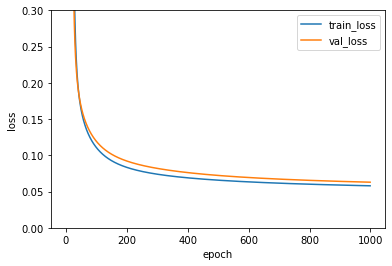

In [21]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

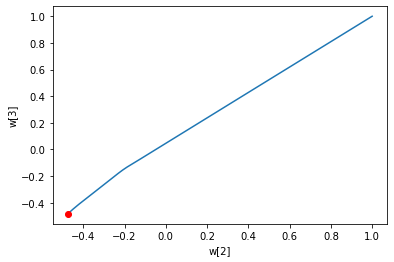

In [22]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

#### 케라스를 이용한 배치경사하강 구현

Epoch 1/100
1/1 [==============================] - 0s 252ms/step - loss: 1.1815 - accuracy: 0.3489 - val_loss: 1.0982 - val_accuracy: 0.4505
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 1.1464 - accuracy: 0.3681 - val_loss: 1.0669 - val_accuracy: 0.4505
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 1.1127 - accuracy: 0.3819 - val_loss: 1.0368 - val_accuracy: 0.4725
Epoch 4/100
1/1 [==============================] - 0s 17ms/step - loss: 1.0804 - accuracy: 0.3984 - val_loss: 1.0080 - val_accuracy: 0.4835
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 1.0495 - accuracy: 0.4038 - val_loss: 0.9803 - val_accuracy: 0.5055
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 1.0198 - accuracy: 0.4176 - val_loss: 0.9538 - val_accuracy: 0.5165
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 0.9914 - accuracy: 0.4341 - val_loss: 0.9284 - val_accuracy: 0.5275
Epoch 8/100
1/1 [==

1/1 [==============================] - 0s 16ms/step - loss: 0.4032 - accuracy: 0.8764 - val_loss: 0.4022 - val_accuracy: 0.8571
Epoch 60/100
1/1 [==============================] - 0s 16ms/step - loss: 0.3995 - accuracy: 0.8764 - val_loss: 0.3987 - val_accuracy: 0.8571
Epoch 61/100
1/1 [==============================] - 0s 17ms/step - loss: 0.3959 - accuracy: 0.8791 - val_loss: 0.3953 - val_accuracy: 0.8571
Epoch 62/100
1/1 [==============================] - 0s 16ms/step - loss: 0.3925 - accuracy: 0.8791 - val_loss: 0.3919 - val_accuracy: 0.8571
Epoch 63/100
1/1 [==============================] - 0s 18ms/step - loss: 0.3891 - accuracy: 0.8819 - val_loss: 0.3887 - val_accuracy: 0.8571
Epoch 64/100
1/1 [==============================] - 0s 16ms/step - loss: 0.3859 - accuracy: 0.8819 - val_loss: 0.3855 - val_accuracy: 0.8681
Epoch 65/100
1/1 [==============================] - 0s 17ms/step - loss: 0.3827 - accuracy: 0.8819 - val_loss: 0.3824 - val_accuracy: 0.8681
Epoch 66/100
1/1 [========

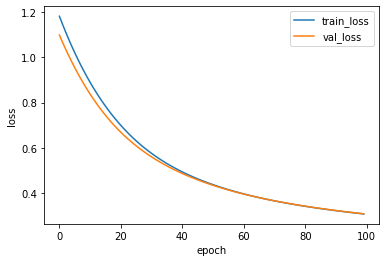

In [24]:
from tensorflow.keras.models import Sequential # 케라스의 Sequential()을 임포트
from tensorflow.keras.layers import Dense      # 케라스의 Dense()를 임포트
from tensorflow.keras import optimizers        # 케라스의 옵티마이저를 임포트
from tensorflow.keras import regularizers

import numpy as np # Numpy를 임포트
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers.experimental import preprocessing

cancer = load_breast_cancer()

x = cancer.data
y = cancer.target

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, 
test_size=0.2, random_state=42)

layer = preprocessing.Normalization()
layer.adapt(x_train) # 메서드를 통해 전처리 레이어의 상태를 훈련 데이터에 노출함으로써 상태를 설정할 수 있습니다.

model=Sequential()
model.add(layer)
model.add(Dense(1, input_dim=30, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
SGD=optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=SGD ,loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train,y_train, batch_size=len(x_train), epochs=100, shuffle=True, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()